In [1]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [2]:
import math
import time
from pathlib import Path
from itertools import cycle
from datetime import timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report,
    roc_curve, auc
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import os
from torchinfo import summary
from torchview import draw_graph

In [3]:
# --------------------------
# Optionally list all directories (using pathlib)
# --------------------------
input_path = Path('/kaggle/input')
for directory in input_path.rglob('*'):
    if directory.is_dir():
        print(directory)

/kaggle/input/Data
/kaggle/input/Data/valid
/kaggle/input/Data/test
/kaggle/input/Data/train
/kaggle/input/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/valid/normal
/kaggle/input/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/kaggle/input/Data/test/squamous.cell.carcinoma
/kaggle/input/Data/test/normal
/kaggle/input/Data/test/adenocarcinoma
/kaggle/input/Data/test/large.cell.carcinoma
/kaggle/input/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
/kaggle/input/Data/train/normal
/kaggle/input/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/kaggle/input/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [4]:
def compute_normalization_stats(dataset_dir, batch_size=32, num_workers=4, image_size=(224, 224)):
    """
    Compute per-channel mean and std for a dataset.
    Images are resized to a fixed size to avoid collation issues.
    """
    temp_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_dir, transform=temp_transform)
    temp_loader = DataLoader(
        temp_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    mean = 0.0
    std = 0.0
    nb_samples = 0

    # Ensure no gradient tracking during statistics computation
    with torch.no_grad():
        for images, _ in temp_loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

def create_transforms(mean, std, image_size=(224, 224)):
    """
    Create training and validation/test transforms using computed statistics.
    """
    train_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    val_test_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    
    return train_transforms, val_test_transforms

def create_datasets_and_loaders(train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=32, num_workers=4):
    """
    Create ImageFolder datasets and DataLoaders with pinned memory.
    """
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=val_test_transforms)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [5]:
def plot_class_distribution(train_dataset, valid_dataset, test_dataset):
    """
    Plot class distribution across train, validation, and test splits.
    """
    train_targets = np.array(train_dataset.targets)
    valid_targets = np.array(valid_dataset.targets)
    test_targets  = np.array(test_dataset.targets)
    
    classes = train_dataset.classes
    num_classes = len(classes)
    
    train_counts = np.bincount(train_targets, minlength=num_classes)
    valid_counts = np.bincount(valid_targets, minlength=num_classes)
    test_counts  = np.bincount(test_targets, minlength=num_classes)
    
    df = pd.DataFrame({
        'Class': classes,
        'Train': train_counts,
        'Validation': valid_counts,
        'Test': test_counts
    })
    print(df)
    
    x = np.arange(num_classes)
    bar_width = 0.6
    
    plt.figure(figsize=(10, 6))
    plt.bar(x, train_counts, bar_width, color='blue', label='Train')
    plt.bar(x, valid_counts, bar_width, bottom=train_counts, color='green', label='Validation')
    plt.bar(x, test_counts, bar_width, bottom=train_counts + valid_counts, color='red', label='Test')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(x, classes, rotation=45)
    plt.title('Stacked Class-wise Distribution: Train, Validation, and Test')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return classes

In [8]:
# Define base directories
data_dir = '/kaggle/input/Data'
# data_dir = '/kaggle/input/lungcancer4types-imagedataset/Data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

In [9]:
# Step 1: Compute normalization statistics from the training set
mean, std = compute_normalization_stats(train_dir, batch_size=8, num_workers=4, image_size=(224, 224))
print("Computed Mean:", mean)
print("Computed Std:", std)

# Optional: Cache computed statistics to a file if desired
# np.save('mean.npy', mean.numpy())
# np.save('std.npy', std.numpy())

# Step 2: Define image transforms using computed statistics
train_transforms, val_test_transforms = create_transforms(mean, std, image_size=(224, 224))

# Step 3: Create datasets and DataLoaders
num_classes = 4
batch_size = 8
num_workers = 4
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = create_datasets_and_loaders(
    train_dir, valid_dir, test_dir, train_transforms, val_test_transforms, batch_size=batch_size, num_workers=num_workers)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))

Computed Mean: tensor([0.3230, 0.3230, 0.3230])
Computed Std: tensor([0.2216, 0.2216, 0.2216])
Training samples: 613
Validation samples: 72
Test samples: 315


                                              Class  Train  Validation  Test
0        adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib    195          23   120
1     large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa    115          21    51
2                                            normal    148          13    54
3  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    155          15    90


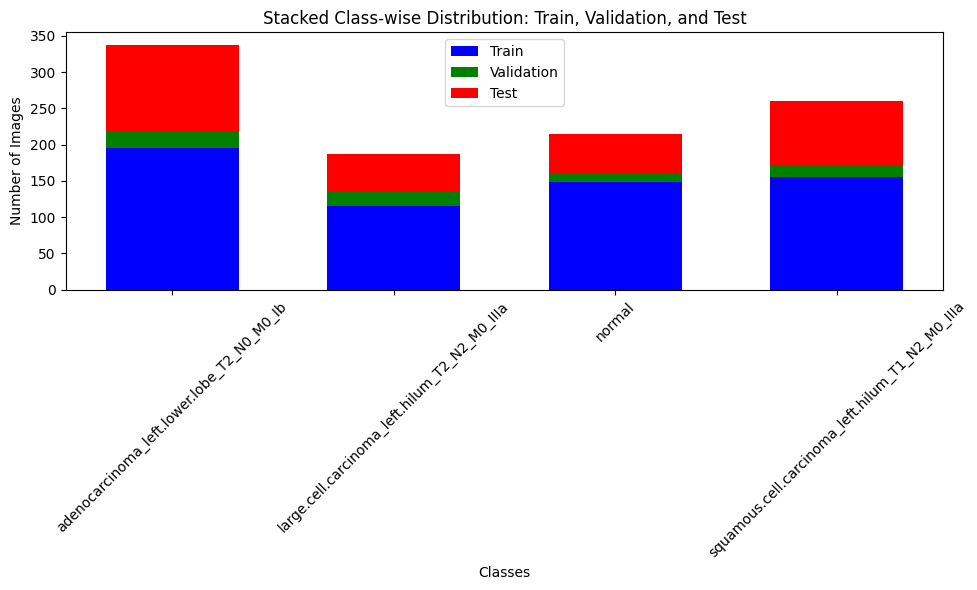

In [10]:
# Step 4: Plot class distribution
classes = plot_class_distribution(train_dataset, valid_dataset, test_dataset)

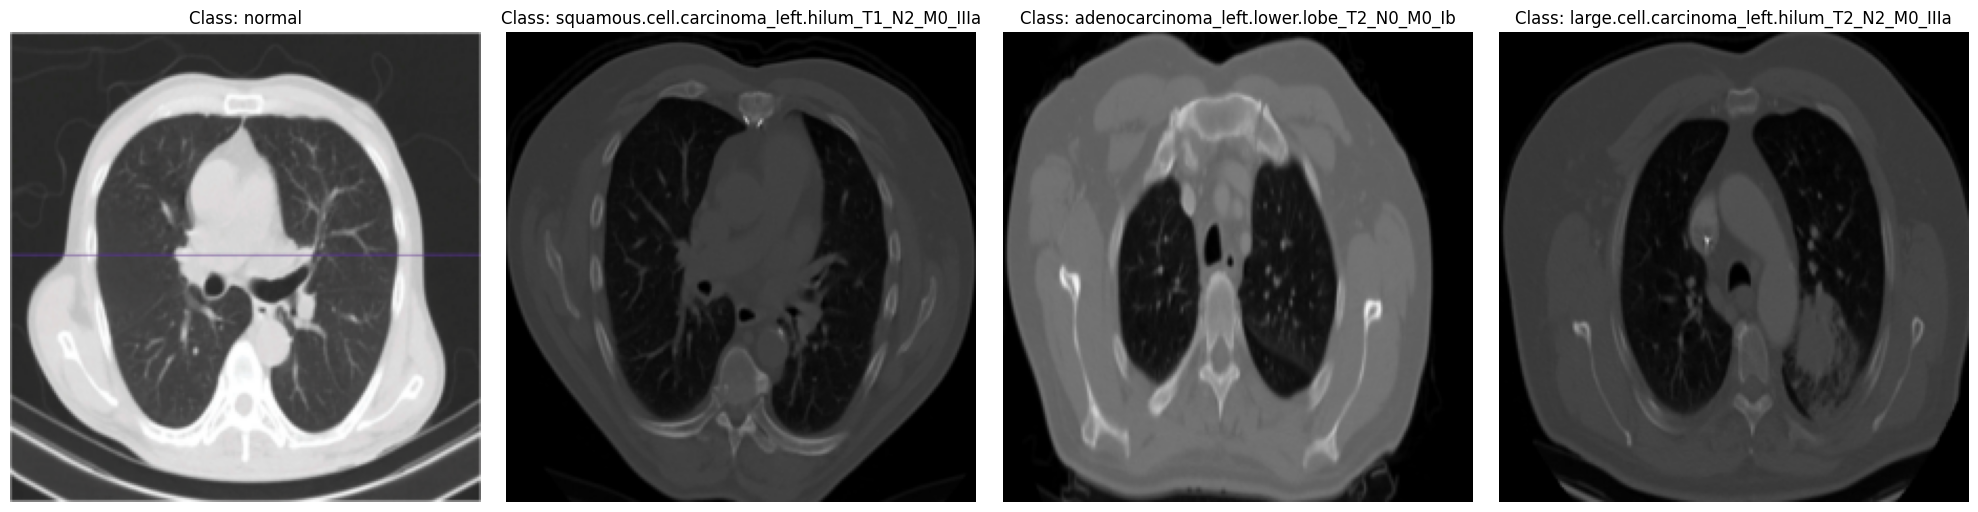

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get class names from the dataset (ImageFolder-style)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Convert mean and std to numpy arrays for unnormalization
mean_np = np.array(mean)[:, None, None]
std_np = np.array(std)[:, None, None]

# Dictionary to store one image per class
random_images_per_class = {}

# Iterate through batches until one image per class is collected
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in random_images_per_class:
            random_images_per_class[label] = img
        if len(random_images_per_class) == len(idx_to_class):
            break
    if len(random_images_per_class) == len(idx_to_class):
        break

# Plot the images
num_classes = len(random_images_per_class)
fig, axs = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
if num_classes == 1:
    axs = [axs]  # Ensure iterable if single class

for ax, (label, img_tensor) in zip(axs, random_images_per_class.items()):
    img_np = img_tensor.cpu().numpy()
    img_np = img_np * std_np + mean_np  # Undo normalization
    img_np = np.clip(img_np, 0, 1)
    img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC

    ax.imshow(img_np)
    ax.set_title(f"Class: {idx_to_class[label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Load the pretrained DeiT-Tiny model
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Replace the classification head
# Original head is: model.head = nn.Linear(192, 1000)
in_features = model.head.in_features
model.head = nn.Linear(in_features, num_classes)

summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:77:

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                        [1, 3, 224, 224]          [1, 4]                    38,016                    True
├─PatchEmbed: 1-1                        [1, 3, 224, 224]          [1, 196, 192]             --                        True
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 192, 14, 14]          147,648                   True
│    └─Identity: 2-2                     [1, 196, 192]             [1, 196, 192]             --                        --
├─Dropout: 1-2                           [1, 197, 192]             [1, 197, 192]             --                        --
├─Identity: 1-3                          [1, 197, 192]             [1, 197, 192]             --                        --
├─Identity: 1-4                          [1, 197, 192]             [1, 197, 192]             --                        --
├─Sequentia

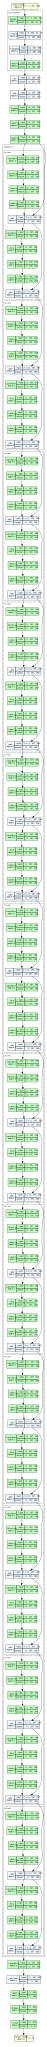

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [15]:
def custom_metrics(y_pred, y_true, loss):
    # Compute predicted classes from probabilities
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Convert tensors to numpy arrays for scikit-learn functions
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()

    # Compute basic metrics
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    # Assuming binary classification for specificity and sensitivity calculations.
    if cm.shape[0] == 2 and cm.shape[1] == 2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = None
        sensitivity = None

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Compute ROC AUC scores per class, only if there are at least 2 unique classes
    num_classes = y_pred.shape[1]
    auc_scores = []
    unique_classes = np.unique(y_true_numpy)
    if len(unique_classes) > 1:
        for class_idx in range(num_classes):
            class_y_true = (y_true_numpy == class_idx).astype(np.float32)
            class_y_pred = y_pred[:, class_idx].cpu().numpy()
            # Skip AUC computation if class_y_true has only one unique value
            if np.all(class_y_true == 0) or np.all(class_y_true == 1):
                continue
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        auc_avg = np.nanmean(auc_scores) if auc_scores else None
    else:
        auc_avg = None

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [16]:
LR = 0.0005
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss() 

In [17]:
# --------------------------
# Initialize
# --------------------------
num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0
best_val_loss = float('inf')
best_model_state = None  # Optional: keep track of best model

# Metric names and history
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {name: [] for name in metric_names}
val_metrics_history = {name: [] for name in metric_names}

# --------------------------
# Training Loop
# --------------------------
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # --- Training ---
    model.train()
    start_time = time.time()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    for data, targets in tqdm(train_loader, desc="Training"):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    epoch_training_time = time.time() - start_time
    total_training_time += epoch_training_time

    avg_train_loss = total_loss / len(train_loader)
    train_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        avg_train_loss
    )

    # Log training metrics
    train_line = "Train Metrics - " + ", ".join([
        f"{k}: {v:.4f}" if v is not None else f"{k}: N/A"
        for k, v in train_metrics.items()
    ])
    print(train_line)
    for name in metric_names:
        train_metrics_history[name].append(train_metrics[name])

    # --- Validation ---
    model.eval()
    start_time = time.time()
    total_loss = 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for data, targets in tqdm(valid_loader, desc="Validating"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_validation_time = time.time() - start_time
    total_validation_time += epoch_validation_time

    avg_val_loss = total_loss / len(valid_loader)
    val_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        avg_val_loss
    )

    # Log validation metrics
    val_line = "Val Metrics   - " + ", ".join([
        f"{k}: {v:.4f}" if v is not None else f"{k}: N/A"
        for k, v in val_metrics.items()
    ])
    print(val_line)
    for name in metric_names:
        val_metrics_history[name].append(val_metrics[name])

    # Optional: Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        print(f"New best validation loss: {best_val_loss:.4f}")

# --------------------------
# Timing Summary
# --------------------------
print("\nTraining Completed.")
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_train_time = total_training_time / num_epochs
avg_val_time = total_validation_time / num_epochs
print(f"Avg Training Time per Epoch: {str(timedelta(seconds=avg_train_time))}")
print(f"Avg Validation Time per Epoch: {str(timedelta(seconds=avg_val_time))}")


Epoch 1/25


Training: 100%|██████████| 77/77 [00:03<00:00, 24.20it/s]
/tmp/ipykernel_35/1206543161.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(all_predictions),


Train Metrics - loss: 1.1615, accuracy: 0.4861, precision: 0.4599, recall: 0.4861, f1_score: 0.4673, specificity: N/A, sensitivity: N/A, mcc: 0.3020, auc: 0.7309


Validating: 100%|██████████| 9/9 [00:00<00:00, 21.51it/s]


Val Metrics   - loss: 1.2307, accuracy: 0.4722, precision: 0.3003, recall: 0.4722, f1_score: 0.3504, specificity: N/A, sensitivity: N/A, mcc: 0.3472, auc: 0.7333
New best validation loss: 1.2307

Epoch 2/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.66it/s]


Train Metrics - loss: 0.9925, accuracy: 0.5253, precision: 0.5124, recall: 0.5253, f1_score: 0.5074, specificity: N/A, sensitivity: N/A, mcc: 0.3545, auc: 0.7805


Validating: 100%|██████████| 9/9 [00:00<00:00, 20.09it/s]


Val Metrics   - loss: 1.0686, accuracy: 0.4028, precision: 0.3297, recall: 0.4028, f1_score: 0.3494, specificity: N/A, sensitivity: N/A, mcc: 0.2415, auc: 0.7562
New best validation loss: 1.0686

Epoch 3/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.16it/s]


Train Metrics - loss: 0.9060, accuracy: 0.5742, precision: 0.5702, recall: 0.5742, f1_score: 0.5545, specificity: N/A, sensitivity: N/A, mcc: 0.4236, auc: 0.8036


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.93it/s]


Val Metrics   - loss: 1.1381, accuracy: 0.4722, precision: 0.5093, recall: 0.4722, f1_score: 0.3580, specificity: N/A, sensitivity: N/A, mcc: 0.3946, auc: 0.7397

Epoch 4/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.29it/s]


Train Metrics - loss: 0.8462, accuracy: 0.6101, precision: 0.6154, recall: 0.6101, f1_score: 0.5918, specificity: N/A, sensitivity: N/A, mcc: 0.4765, auc: 0.8206


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.05it/s]


Val Metrics   - loss: 1.0345, accuracy: 0.4167, precision: 0.3475, recall: 0.4167, f1_score: 0.3684, specificity: N/A, sensitivity: N/A, mcc: 0.2231, auc: 0.7723
New best validation loss: 1.0345

Epoch 5/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.64it/s]


Train Metrics - loss: 0.8192, accuracy: 0.6264, precision: 0.6334, recall: 0.6264, f1_score: 0.6091, specificity: N/A, sensitivity: N/A, mcc: 0.5013, auc: 0.8310


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.87it/s]


Val Metrics   - loss: 1.1914, accuracy: 0.4306, precision: 0.3527, recall: 0.4306, f1_score: 0.3817, specificity: N/A, sensitivity: N/A, mcc: 0.2484, auc: 0.7708

Epoch 6/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.74it/s]


Train Metrics - loss: 0.8015, accuracy: 0.6542, precision: 0.6554, recall: 0.6542, f1_score: 0.6468, specificity: N/A, sensitivity: N/A, mcc: 0.5330, auc: 0.8434


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.58it/s]


Val Metrics   - loss: 1.0541, accuracy: 0.4722, precision: 0.5066, recall: 0.4722, f1_score: 0.3671, specificity: N/A, sensitivity: N/A, mcc: 0.3538, auc: 0.7694

Epoch 7/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.50it/s]


Train Metrics - loss: 0.7415, accuracy: 0.6900, precision: 0.6957, recall: 0.6900, f1_score: 0.6848, specificity: N/A, sensitivity: N/A, mcc: 0.5820, auc: 0.8610


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.54it/s]


Val Metrics   - loss: 1.4582, accuracy: 0.4861, precision: 0.3504, recall: 0.4861, f1_score: 0.4008, specificity: N/A, sensitivity: N/A, mcc: 0.3374, auc: 0.7494

Epoch 8/25


Training: 100%|██████████| 77/77 [00:03<00:00, 24.86it/s]


Train Metrics - loss: 0.7278, accuracy: 0.6933, precision: 0.6892, recall: 0.6933, f1_score: 0.6878, specificity: N/A, sensitivity: N/A, mcc: 0.5861, auc: 0.8608


Validating: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s]


Val Metrics   - loss: 0.9509, accuracy: 0.4583, precision: 0.5089, recall: 0.4583, f1_score: 0.4552, specificity: N/A, sensitivity: N/A, mcc: 0.2926, auc: 0.7797
New best validation loss: 0.9509

Epoch 9/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.76it/s]


Train Metrics - loss: 0.6948, accuracy: 0.7178, precision: 0.7214, recall: 0.7178, f1_score: 0.7137, specificity: N/A, sensitivity: N/A, mcc: 0.6198, auc: 0.8686


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.20it/s]


Val Metrics   - loss: 0.8762, accuracy: 0.5139, precision: 0.5591, recall: 0.5139, f1_score: 0.5187, specificity: N/A, sensitivity: N/A, mcc: 0.3483, auc: 0.8210
New best validation loss: 0.8762

Epoch 10/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.35it/s]


Train Metrics - loss: 0.6556, accuracy: 0.7194, precision: 0.7176, recall: 0.7194, f1_score: 0.7165, specificity: N/A, sensitivity: N/A, mcc: 0.6210, auc: 0.8869


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.44it/s]


Val Metrics   - loss: 1.0391, accuracy: 0.4722, precision: 0.4163, recall: 0.4722, f1_score: 0.4031, specificity: N/A, sensitivity: N/A, mcc: 0.3241, auc: 0.7541

Epoch 11/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.21it/s]


Train Metrics - loss: 0.5867, accuracy: 0.7553, precision: 0.7634, recall: 0.7553, f1_score: 0.7521, specificity: N/A, sensitivity: N/A, mcc: 0.6716, auc: 0.8979


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.39it/s]


Val Metrics   - loss: 1.1293, accuracy: 0.4583, precision: 0.3659, recall: 0.4583, f1_score: 0.3999, specificity: N/A, sensitivity: N/A, mcc: 0.2979, auc: 0.8076

Epoch 12/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.67it/s]


Train Metrics - loss: 0.5186, accuracy: 0.7896, precision: 0.7969, recall: 0.7896, f1_score: 0.7887, specificity: N/A, sensitivity: N/A, mcc: 0.7162, auc: 0.9229


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.55it/s]


Val Metrics   - loss: 0.8757, accuracy: 0.5556, precision: 0.6167, recall: 0.5556, f1_score: 0.5434, specificity: N/A, sensitivity: N/A, mcc: 0.4150, auc: 0.8220
New best validation loss: 0.8757

Epoch 13/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.28it/s]


Train Metrics - loss: 0.5934, accuracy: 0.7553, precision: 0.7608, recall: 0.7553, f1_score: 0.7530, specificity: N/A, sensitivity: N/A, mcc: 0.6695, auc: 0.9094


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.69it/s]


Val Metrics   - loss: 1.0467, accuracy: 0.4861, precision: 0.5095, recall: 0.4861, f1_score: 0.4570, specificity: N/A, sensitivity: N/A, mcc: 0.3215, auc: 0.7758

Epoch 14/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.95it/s]


Train Metrics - loss: 0.6080, accuracy: 0.7569, precision: 0.7544, recall: 0.7569, f1_score: 0.7533, specificity: N/A, sensitivity: N/A, mcc: 0.6718, auc: 0.8985


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.43it/s]


Val Metrics   - loss: 1.3048, accuracy: 0.4444, precision: 0.5245, recall: 0.4444, f1_score: 0.4360, specificity: N/A, sensitivity: N/A, mcc: 0.2887, auc: 0.8143

Epoch 15/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.60it/s]


Train Metrics - loss: 0.5631, accuracy: 0.7569, precision: 0.7591, recall: 0.7569, f1_score: 0.7561, specificity: N/A, sensitivity: N/A, mcc: 0.6718, auc: 0.9207


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.53it/s]


Val Metrics   - loss: 1.2008, accuracy: 0.5556, precision: 0.5764, recall: 0.5556, f1_score: 0.5110, specificity: N/A, sensitivity: N/A, mcc: 0.4245, auc: 0.7745

Epoch 16/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.96it/s]


Train Metrics - loss: 0.4403, accuracy: 0.8303, precision: 0.8300, recall: 0.8303, f1_score: 0.8291, specificity: N/A, sensitivity: N/A, mcc: 0.7712, auc: 0.9481


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.72it/s]


Val Metrics   - loss: 1.6865, accuracy: 0.4583, precision: 0.3803, recall: 0.4583, f1_score: 0.4028, specificity: N/A, sensitivity: N/A, mcc: 0.2941, auc: 0.7508

Epoch 17/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.91it/s]


Train Metrics - loss: 0.4831, accuracy: 0.7993, precision: 0.7978, recall: 0.7993, f1_score: 0.7957, specificity: N/A, sensitivity: N/A, mcc: 0.7298, auc: 0.9264


Validating: 100%|██████████| 9/9 [00:00<00:00, 18.85it/s]


Val Metrics   - loss: 1.2538, accuracy: 0.5000, precision: 0.5487, recall: 0.5000, f1_score: 0.4905, specificity: N/A, sensitivity: N/A, mcc: 0.3694, auc: 0.7621

Epoch 18/25


Training: 100%|██████████| 77/77 [00:03<00:00, 24.65it/s]


Train Metrics - loss: 0.4544, accuracy: 0.8026, precision: 0.8045, recall: 0.8026, f1_score: 0.8025, specificity: N/A, sensitivity: N/A, mcc: 0.7334, auc: 0.9346


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.38it/s]


Val Metrics   - loss: 1.0001, accuracy: 0.5139, precision: 0.5384, recall: 0.5139, f1_score: 0.5172, specificity: N/A, sensitivity: N/A, mcc: 0.3527, auc: 0.8043

Epoch 19/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.05it/s]


Train Metrics - loss: 0.3409, accuracy: 0.8679, precision: 0.8691, recall: 0.8679, f1_score: 0.8681, specificity: N/A, sensitivity: N/A, mcc: 0.8216, auc: 0.9627


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.30it/s]


Val Metrics   - loss: 1.8706, accuracy: 0.4583, precision: 0.3503, recall: 0.4583, f1_score: 0.3551, specificity: N/A, sensitivity: N/A, mcc: 0.3289, auc: 0.7361

Epoch 20/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.17it/s]


Train Metrics - loss: 0.3188, accuracy: 0.8793, precision: 0.8798, recall: 0.8793, f1_score: 0.8788, specificity: N/A, sensitivity: N/A, mcc: 0.8374, auc: 0.9686


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.22it/s]


Val Metrics   - loss: 1.2799, accuracy: 0.4583, precision: 0.4760, recall: 0.4583, f1_score: 0.4191, specificity: N/A, sensitivity: N/A, mcc: 0.2838, auc: 0.8177

Epoch 21/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.21it/s]


Train Metrics - loss: 0.3826, accuracy: 0.8515, precision: 0.8524, recall: 0.8515, f1_score: 0.8518, specificity: N/A, sensitivity: N/A, mcc: 0.7995, auc: 0.9567


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.99it/s]


Val Metrics   - loss: 1.6162, accuracy: 0.3889, precision: 0.4642, recall: 0.3889, f1_score: 0.3818, specificity: N/A, sensitivity: N/A, mcc: 0.2318, auc: 0.7576

Epoch 22/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.03it/s]


Train Metrics - loss: 0.3314, accuracy: 0.8793, precision: 0.8789, recall: 0.8793, f1_score: 0.8790, specificity: N/A, sensitivity: N/A, mcc: 0.8372, auc: 0.9707


Validating: 100%|██████████| 9/9 [00:00<00:00, 22.95it/s]


Val Metrics   - loss: 1.6518, accuracy: 0.4583, precision: 0.4757, recall: 0.4583, f1_score: 0.4240, specificity: N/A, sensitivity: N/A, mcc: 0.2954, auc: 0.7376

Epoch 23/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.35it/s]


Train Metrics - loss: 0.3290, accuracy: 0.8891, precision: 0.8884, recall: 0.8891, f1_score: 0.8886, specificity: N/A, sensitivity: N/A, mcc: 0.8503, auc: 0.9646


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.37it/s]


Val Metrics   - loss: 1.3500, accuracy: 0.5278, precision: 0.5654, recall: 0.5278, f1_score: 0.5321, specificity: N/A, sensitivity: N/A, mcc: 0.3746, auc: 0.7873

Epoch 24/25


Training: 100%|██████████| 77/77 [00:02<00:00, 26.42it/s]


Train Metrics - loss: 0.2665, accuracy: 0.9168, precision: 0.9168, recall: 0.9168, f1_score: 0.9168, specificity: N/A, sensitivity: N/A, mcc: 0.8878, auc: 0.9760


Validating: 100%|██████████| 9/9 [00:00<00:00, 21.99it/s]


Val Metrics   - loss: 1.4756, accuracy: 0.5972, precision: 0.6492, recall: 0.5972, f1_score: 0.5665, specificity: N/A, sensitivity: N/A, mcc: 0.4848, auc: 0.7745

Epoch 25/25


Training: 100%|██████████| 77/77 [00:02<00:00, 27.73it/s]


Train Metrics - loss: 0.2890, accuracy: 0.8858, precision: 0.8853, recall: 0.8858, f1_score: 0.8855, specificity: N/A, sensitivity: N/A, mcc: 0.8460, auc: 0.9734


Validating: 100%|██████████| 9/9 [00:00<00:00, 23.31it/s]


Val Metrics   - loss: 1.7391, accuracy: 0.5000, precision: 0.5755, recall: 0.5000, f1_score: 0.4781, specificity: N/A, sensitivity: N/A, mcc: 0.3888, auc: 0.7620

Training Completed.
Total Training Time: 0:01:12.157316
Total Validation Time: 0:00:10.049448
Avg Training Time per Epoch: 0:00:02.886293
Avg Validation Time per Epoch: 0:00:00.401978


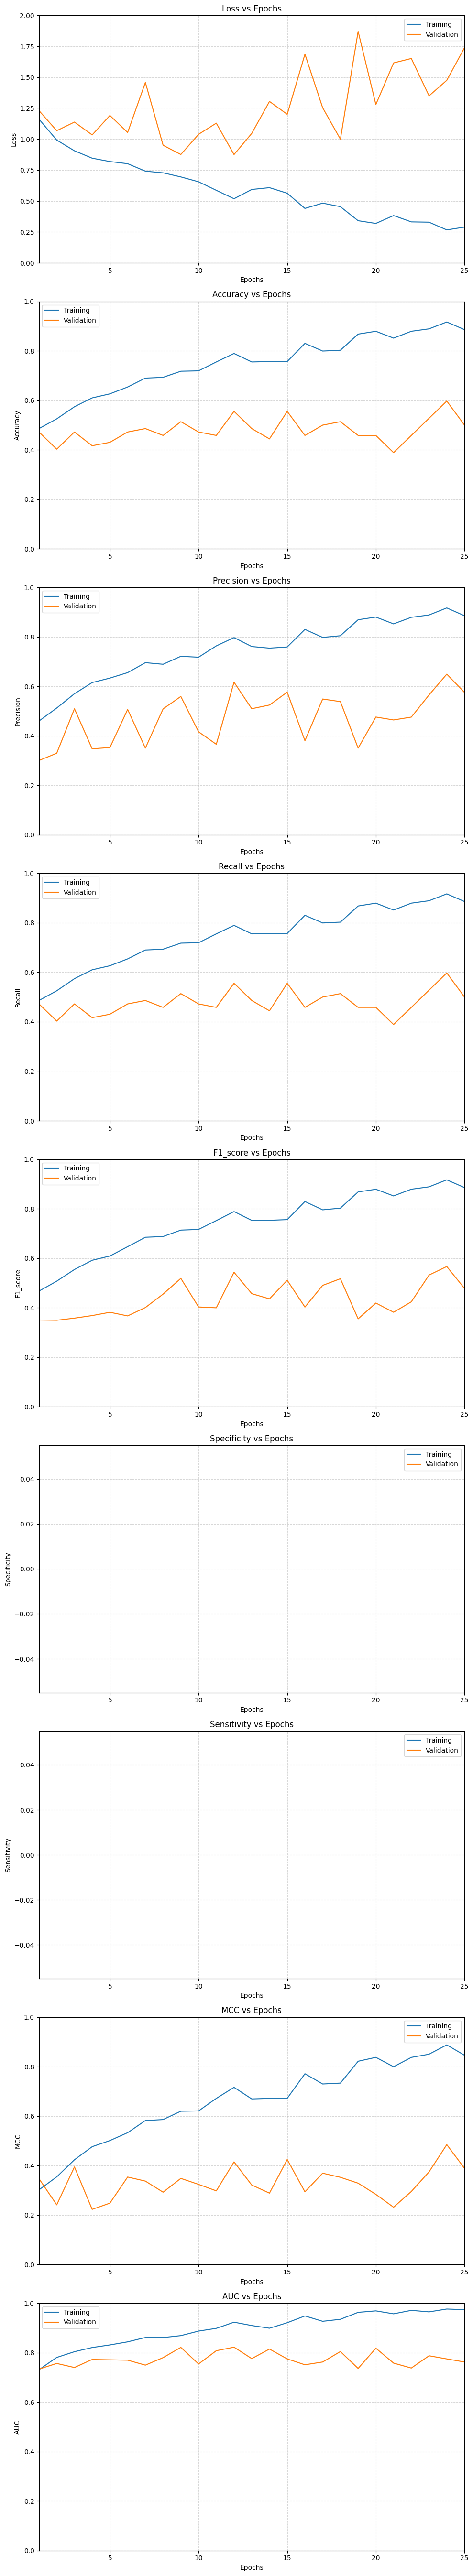

In [18]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    
    # Create subplots. If there's only one metric, axes is made into a list.
    if num_metrics == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    
    rng = range(1, num_epochs + 1)
    
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        
        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")
        
        # Filter out None values before computing y-axis limits.
        valid_train = [m for m in train_metric if m is not None]
        valid_val = [m for m in val_metric if m is not None]
        
        if valid_train or valid_val:
            max_metric = max((max(valid_train) if valid_train else float('-inf')),
                             (max(valid_val) if valid_val else float('-inf')))
            min_metric = min((min(valid_train) if valid_train else float('inf')),
                             (min(valid_val) if valid_val else float('inf')))
            y_max = math.ceil(max_metric)
            if min_metric > 0 or max_metric > 1:
                ax.set_ylim(0, y_max)
            else:
                ax.set_ylim(min_metric, y_max)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        # Only set x-axis limits if there is more than one epoch.
        if num_epochs > 1:
            ax.set_xlim(1, num_epochs)
    
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [19]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_value is None:
        testing_metrics_line += f"{metric_name}: N/A, "
    elif metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)

Testing Model: 100%|██████████| 40/40 [00:01<00:00, 29.73it/s]


Metrics - loss: 1.2793, accuracy: 0.5746, precision: 0.6099, recall: 0.5746, f1_score: 0.5620, specificity: N/A, sensitivity: N/A, mcc: 0.4396, auc: 0.8261


In [20]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.5821    0.3250    0.4171       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.5385    0.4118    0.4667        51
                                          normal     1.0000    0.8889    0.9412        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.4534    0.8111    0.5817        90

                                        accuracy                         0.5746       315
                                       macro avg     0.6435    0.6092    0.6017       315
                                    weighted avg     0.6099    0.5746    0.5620       315

There were 134 errors in 315 tests for an accuracy of  57.46


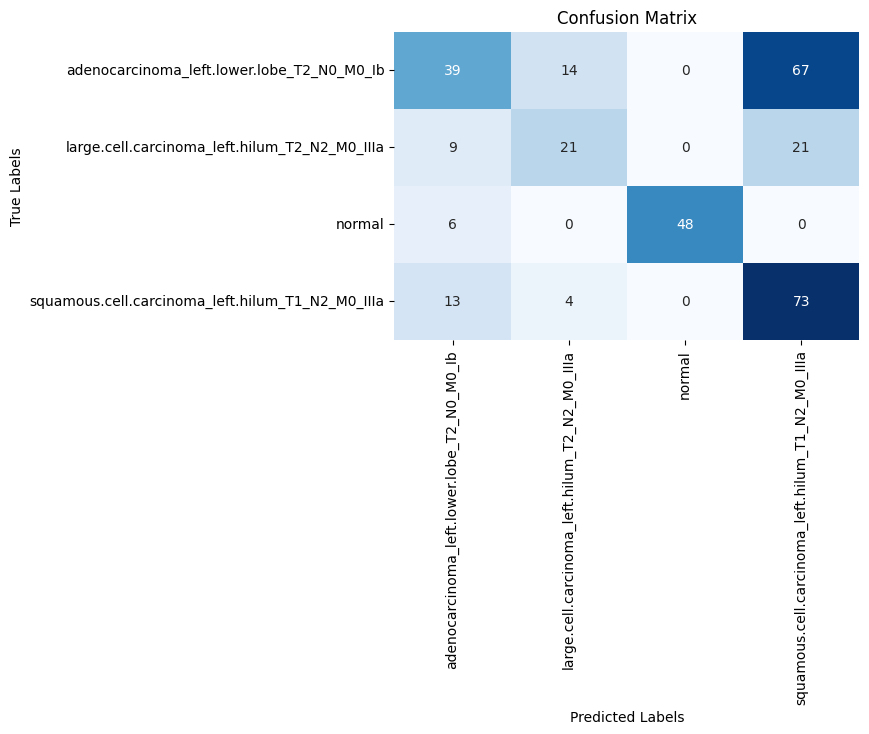

In [21]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
# --- Step 1: Gather True Labels and Predicted Probabilities ---
true_labels = []
predicted_probs = []

# Ensure model is in evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Processing test batches"):
        images = images.to(next(model.parameters()).device)
        outputs = model(images)  # Assuming model outputs logits or probabilities
        # If outputs are logits, apply softmax
        probabilities = torch.softmax(outputs, dim=1)
        
        predicted_probs.append(probabilities.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Concatenate batches
predicted_probs = np.concatenate(predicted_probs, axis=0)  # shape: (n_samples, n_classes)
true_labels = np.concatenate(true_labels, axis=0)          # shape: (n_samples,)

# If true_labels are not one-hot encoded, convert them:
if true_labels.ndim == 1:
    num_classes = predicted_probs.shape[1]
    true_labels_onehot = label_binarize(true_labels, classes=range(num_classes))
else:
    num_classes = true_labels.shape[1]
    true_labels_onehot = true_labels

# Ensure we have a list of class names of the right length.
try:
    if len(classes) != num_classes:
        classes = [f"Class {i}" for i in range(num_classes)]
except NameError:
    classes = [f"Class {i}" for i in range(num_classes)]

Processing test batches: 100%|██████████| 40/40 [00:01<00:00, 31.34it/s]


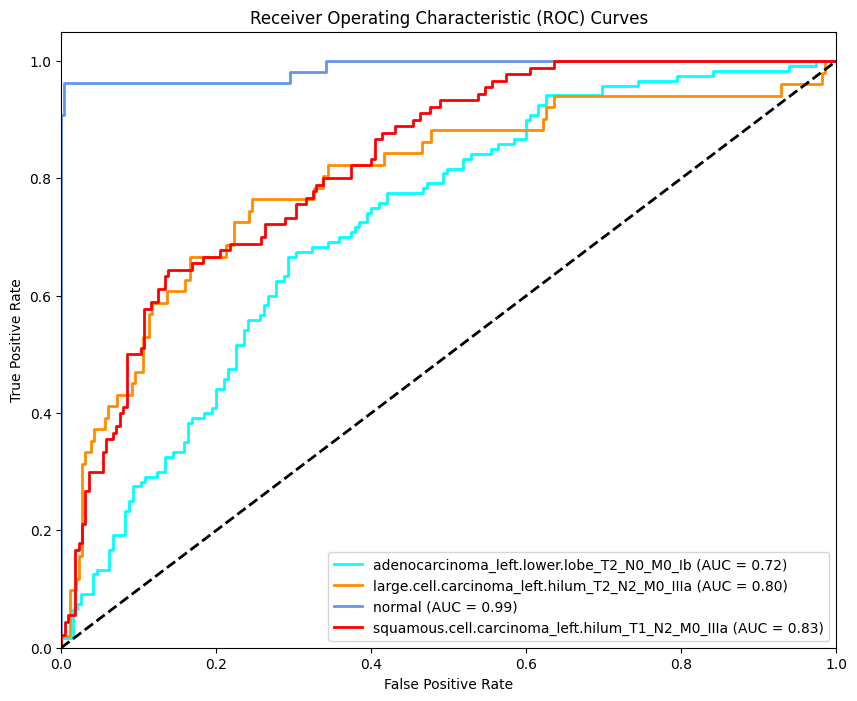

Saved ROC plot with only curves as 'roc_plot_no_labels.png'


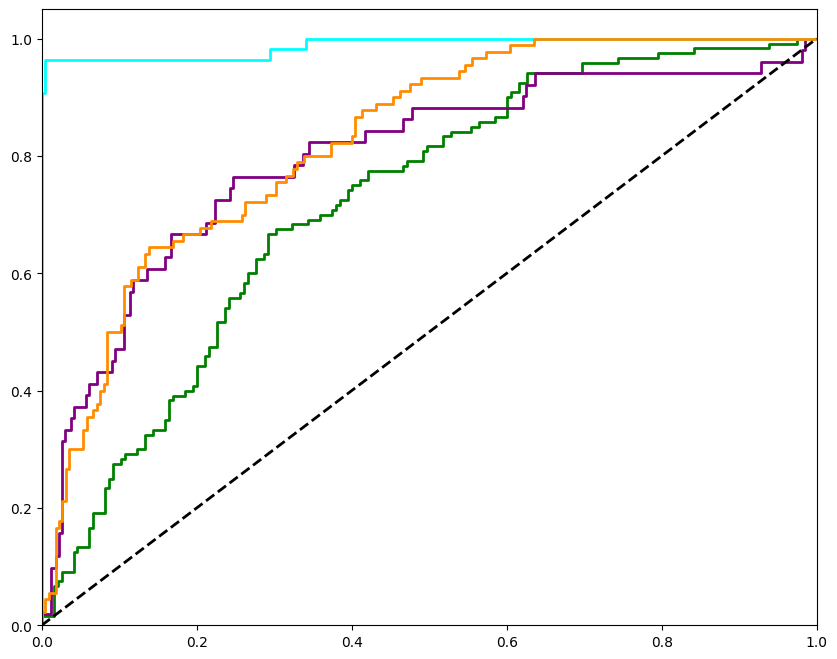

In [23]:
# --- Step 2: Compute ROC Curve and AUC for Each Class ---
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    # This may trigger UndefinedMetricWarning if there are no positive samples for a class.
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 3: Create the ROC Plot with Labels ---
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# --- Optional: Create a version without any labels (curves only) ---
fig, ax = plt.subplots(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.savefig("roc_plot_no_labels.png", bbox_inches='tight')
print("Saved ROC plot with only curves as 'roc_plot_no_labels.png'")
plt.show()

In [24]:
# --- Step 4: Save the ROC Data to an Excel File ---
excel_filename = "roc_data.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    for i in range(num_classes):
        df = pd.DataFrame({
            'FPR': fpr[i],
            'TPR': tpr[i]
        })
        df['AUC'] = roc_auc[i]  # Same value for all rows
        # Excel sheet names are limited to 31 characters.
        sheet_name = classes[i][:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"ROC metrics saved to {excel_filename}")

ROC metrics saved to roc_data.xlsx
